# Introduction #

This notebook is very similar to the salad training tutorial found here: https://colab.research.google.com/drive/1WU_-NPMM_kqaz0fpXXCWj-QQ0hybpJMD. There are a few differences however:

*   Much more aligned to our autonomous vehicle scenario, we will be using a road sign dataset that is publicly available at Kaggle, a web platform community for data science and machine learning that hosts a variety of datasets
*   Unlike the salads dataset that was in a .csv format, this dataset uses the PASCAL VOC annotation format, which we will learn about here.

The dataset that we will be using for this tutorial is derived from the one published here: https://www.kaggle.com/datasets/andrewmvd/road-sign-detection. This dataset contains road signs of four different categories:

*   traffic lights (which aren't a road sign per se, but still useful to detect);
*   stop signs;
*   speed limit signs; and,
*   crosswalk signs.

We will be training a model that recognizes these four different road signs  that you can load onto your Coral USB Accelerator. Most of the steps below are similar to those seen in the salad training tutorial, and should look familiar.

## Notes About This Tutorial ##
Some important notes to consider before embarking on this tutorial:

*    You should definitely run this notebook using a GPU runtime (a T4, L4, or A100 GPU runtime). Only the T4 runtime is available in the free tier of Colab, the other GPUs require a subscription to Colab Pro (\$14 CAD per month) or a Pay-As-You-Go plan (~\$14 CAD for 100 compute units).
*    For this tutorial, you will need to upload and download files from the runtime. Before closing or disconnecting from your runtime, be sure to download and save any files (e.g., models) that are needed. Otherwise, they will be wiped and you will lose those files.
*    This tutorial was adapted from one originally provided by [Google](https://colab.research.google.com/github/google-coral/tutorials/blob/master/retrain_efficientdet_model_maker_tf2.ipynb). The old tutorial no longer works on Colab in its current state as Colab has upgraded the CUDA and Python versions on their hosted runtimes, which are incompatable with the `EfficientDet` retraining process described in the original notebook. I have adapted the original tutorial to allow students to retrain the EfficienDet model using the current Colab runtimes (as of December 2025). See the salad training notebook for details of how this was done.

# Set up Virtual Environment #

TensorFlow Lite Model Maker is only compatible with Python 3.9. Unfortunately, Google Colab uses Python 3.10+. The solution to this issue is to run Google Colab using Python 3.9 using a [virtual environment](https://docs.python.org/3/library/venv.html). I'll explain what a virtual environment in a little bit.

## Install Miniconda ##
Here, we use [Miniconda](https://www.anaconda.com/docs/getting-started/miniconda/main), a distribution of Python, to help us create a Python 3.9 virtual environment.

The cell below downloads and installs Miniconda.

In [ ]:
!wget https://repo.anaconda.com/miniconda/Miniconda3-py39_23.3.1-0-Linux-x86_64.sh
!chmod +x Miniconda3-py39_23.3.1-0-Linux-x86_64.sh
!./Miniconda3-py39_23.3.1-0-Linux-x86_64.sh -b -f -p /usr/local
!conda update -y conda

## Create `myenv` Virtual Envrionment ##

The following cell activates Python virtual environment using the Miniconda. Python virtual environments (venvs) are isolated directories that allow developers to install and run specific versions of Python and its libraries without affecting the system-wide Python installation.

For example, suppose one of your projects that you are working on uses an older version of OpenCV, and another project uses a newer version. If you're working on both projects on the same machine, trying to work on one project and then switching to the other project may cause dependency conflicts around OpenCV. Having each project in its own venv allows the dependancies of each project to be completely isolated, eliminating such conflicts.

The cell below creates a conda virtual environment called `myenv` and installs Python 3.9 in this environment.



In [ ]:
import sys
sys.path.append('/usr/local/lib/python3.9/site-packages')
!conda create -y -n myenv python=3.9

## Check Python Version ##

This checks the python version to ensure that colab is running Python 3.9.

In [ ]:
! python3 --version

## Install Dependencies in `myenv` ##

The next lines install the following Python packages in our `myenv` environment:

*   [**tflite-model-maker**](https://pypi.org/project/tflite-model-maker/): needed for creating our training model
*   [**ipykernel**](https://pypi.org/project/ipykernel/): provides the Python interpreter kernel for Jupyter
*   [**numpy**](https://numpy.org/doc/stable/user/whatisnumpy.html): a library that provides tools for working with arrays and matrices
*   [**matplotlibb**](https://matplotlib.org/): a library for creating visualizations
*   [**pycocotools**](https://pypi.org/project/pycocotools/): containing the APIs of the [MS-COCO](https://cocodataset.org) dataset for reading and visualizing annotations

You don't really need to know the details of these packages, they are just dependancies that we need to run the rest of this retraining tutorial.

Note: Don't worry about the version errors that pop up regarding version compatibility of `matplotlib`.

In [ ]:
%%shell
eval "$(conda shell.bash hook)"
conda activate myenv

pip install tflite-model-maker
pip install ipykernel==5.5.6
pip install numpy==1.23.2
pip install matplotlib==3.7.5
pip install pycocotools==2.0.7

In the cell below, we will install NVidia `cuda` and `cudnn` that will allow us to use NVidia GPUs or TPUs for retraining our EfficientDet model.

In [ ]:
%%shell
eval "$(conda shell.bash hook)"
conda activate myenv

conda install -y -n base conda-libmamba-solver
conda install -y conda-forge::cudatoolkit==11.7.0 --solver=libmamba
conda install -y conda-forge::cudnn==8.9.7.29 --solver=libmamba


# Upload Dataset to Runtime #

In this tutorial, you'll use the publicly available Road Sign Detection dataset which can be found here: https://www.kaggle.com/datasets/andrewmvd/road-sign-detection. However, instead of downloading the dataset directly off Kaggle and uploading to the Colab runtime, you will have a much easier time if you download the euro_road_sign_dataset.zip file off of the ELEC 390 SharePoint (https://queensuca.sharepoint.com/:u:/r/teams/CCT-938446/Shared%20Documents/Tutorials/02-EuroRoadSignDetector/euro_road_sign_dataset.zip?csf=1&web=1&e=QHhWVy).

It should be noted that there are two differences between the original dataset found on Kaggle, and the one on the SharePoint:

*   The original images in the dataset use the PNG image format. In order for this dataset to work with the tflite-model-maker, conversion of these images to JPG was necessary.
*   Subsequently, the file names in each of the annotation xml files needed to change as well to reflect the change in image extension.

The steps to get the dataset uploaded to the runtime are as follows:
1.   Download the zip folder of the dataset from the ELEC 390 SharePoint to your computer: https://queensuca.sharepoint.com/:u:/r/teams/CCT-938446/Shared%20Documents/Tutorials/02-EuroRoadSignDetector/euro_road_sign_dataset.zip?csf=1&web=1&e=QHhWVy
2.   On the left hand side of Colab, click on the folder icon to open up the file pane.
3.   Either drag-and-drop the downloaded dataset to Colab's file pane or use the upload button to upload the dataset to the runtime as shown in the figure below.

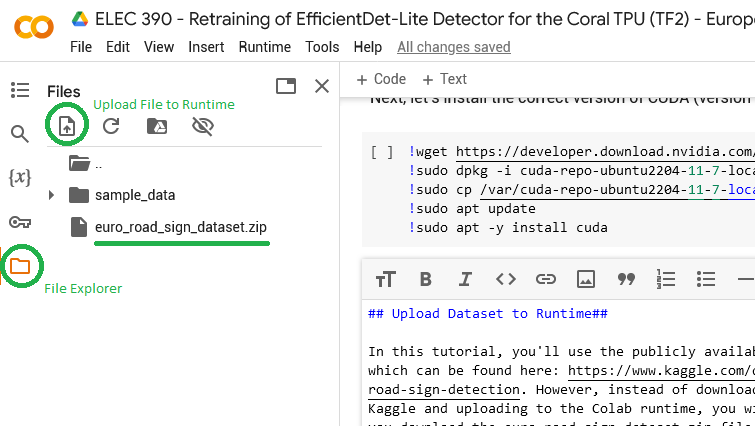

4.   Now that we have the dataset in our runtime, let's unzip it using the following terminal command:

In [ ]:
!unzip euro_road_sign_dataset.zip

Once finished, you'll have a new folder called "dataset" which contains two sub-folders: images and annotations. Let's take a look into each one.

In the `images` folder, you will find 877 `.jpg` images named `road###.jpg` where `###` represents a one, two or three digit number. If you examine some of the photos, you will see that they are of traffic lights, stop signs, European speed limit signs, or crosswalk signs. You will also notice that all of the photos are fairly small, generally 300 x 400 pixels.

In the `annotation` folder, you find 877 `,xml` files that are similarily named to the images with the format `road###.xml`, where `###` again represents a one, two or three digit number. If you assume that each `.xml` file corresponds to a image file, you would be right. If you open up any `.xml` file, you'll see several XML tags that describe the folder, image size, and name of file of the corresponding image. Additionally, you will also have details about "objects" that appear in the image; most importantly, the description of the bounding box that describes the locationand size of the object in the image in terms of min/max x and y pixel coordinates.  The other object tags, including "pose", "occluded" (if the object is blocked by another object in the image), and "truncated" (if more thana 15-20% of the object is occluded and lies outside the bounding box), are not as important and not typically used. Sometimes you'll notice that a xml may contain two objects - for example, see road11.xml and corresponding image `road11.jpg`.



```
<annotation>
  <folder>images</folder>
  <filename>road11.jpg</filename>
  <size>
    <width>400</width>
    <height>300</height>
    <depth>3</depth>
  </size>
  <segmented>0</segmented>
  <object>
    <name>trafficlight</name>
    <pose>Unspecified</pose>
    <truncated>0</truncated>
    <occluded>0</occluded>
    <difficult>0</difficult>
    <bndbox>
      <xmin>188</xmin>
      <ymin>98</ymin>
      <xmax>207</xmax>
      <ymax>132</ymax>
    </bndbox>
  </object>
  <object>
    <name>trafficlight</name>
    <pose>Unspecified</pose>
    <truncated>0</truncated>
    <occluded>0</occluded>
    <difficult>0</difficult>
    <bndbox>
      <xmin>317</xmin>
      <ymin>172</ymin>
      <xmax>331</xmax>
      <ymax>200</ymax>
    </bndbox>
  </object>
```

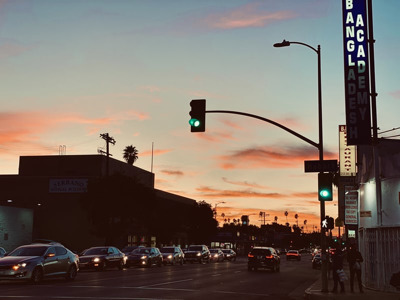

This xml file in the "annotations" folder along with its corresponding image in the "images" folder follows what is called the Pascal VOC (Visual Object Classes) annototation format - which is one of the [earlier established benchmarks for object classification and detection](https://link.springer.com/article/10.1007/s11263-009-0275-4).

You may wish to take note of this format as this will be one of the formats that you can use for creating custom datasets (like the ones needed to allow your vehicle to perform object avoidance).

# Train the Model #

For this step, you'll need to ensure that you have uploaded the following Python scripts to your runtime's file folder:

*   `train_road_signs_model.py`
*   `split_dataset.py`

These Python scripts can be found in the ELEC 392 Course SharePoint. Download these files to your computer and then simply drag and drop them into the files pane on the left hand side of your Colab window (similar to what you did with the dataset zip in the previous step). Double click the Python files to examine their code. There are some comments that will help you with understanding what's going on under the hood.

The next command will run the script and train the road signs detection model. Training using a T4 GPU runtime will take approximately 20 minutes. Testing of the models will take another 20 minutes.

In [ ]:
%%shell
eval "$(conda shell.bash hook)"
conda activate myenv

export LD_LIBRARY_PATH=$CONDA_PREFIX/lib:$LD_LIBRARY_PATH
echo $LD_LIBRARY_PATH

python train_road_signs_model.py

In the outputs above, you will see a bunch of values that are calculated after each epoch such as `det_loss`, `cls_loss`, and `box_loss`. Generally speaking, loss measures the difference between the predicted and actual values. The lower the loss, the better a model (unless the model has over-fitted to the training data). The loss is calculated on training and validation and its interperation is how well the model is doing for these two sets. Unlike accuracy, loss is not a percentage. It is a summation of the errors made for each example in training or validation sets. Then naturally, the main objective in a learning model is to reduce (minimize) the loss function's value with respect to the model's parameters by changing the weight vector values through different optimization methods, such as backpropagation in neural networks (which is what is being done in each epoch). Loss value implies how well or poorly a certain model behaves after each iteration of optimization. Ideally, one would expect the reduction of loss after each, or several, iteration(s).

The accuracy of a model is usually determined after the model parameters are learned and fixed and no learning is taking place. Then the test samples are fed to the model and the number of mistakes (zero-one loss) the model makes are recorded, after comparison to the true targets. Then the percentage of misclassification is calculated.

You'll notice that a new file appears in your Colab's runtime directory: `efficientdet-lite-road-signs.tflite`. This is your TensorFlow model that will detect traffic lights, stop signs, European speed limit signs, and European pedestrian crosswalk signs.

# Testing the Model #
Let's test out the model ourselves with an image from the test set. To simplify our code, we'll use the [PyCoral API](https://www.coral.ai/docs/reference/py/) which we'll download using `pip`.

In [ ]:
%%shell
eval "$(conda shell.bash hook)"
conda activate myenv

pip install --extra-index-url https://google-coral.github.io/py-repo/ pycoral
pip install Pillow==9.5.0

In [ ]:
%%shell
eval "$(conda shell.bash hook)"
conda activate myenv

python test_road_signs_model.py

In [ ]:
import os
import matplotlib.pyplot as plt
img = plt.imread('road-sign-detect-result.jpg')
plt.imshow(img)

## Compiling the TFLite Model for Edge TPU ##

Now that we have the TFLite model, it is possible to simply download it and run it off the Raspberry Pi. The problem is that the model won't run on the Edge TPU (Coral USB Accelerator). Instead, it will run off of the Pi's CPU, and detection will be incredibly slow - maybe a few frames per second if you're lucky.  

To run the model on the Edge TPU, we'll need to compile the model into a format that can be loaded on the Edge TPU. To do this, we will first need to download the Edge TPU Compiler:

In [ ]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list
! sudo apt-get update
! sudo apt-get install edgetpu-compiler

Before compiling the `.tflite` file for the Edge TPU, it's important to consider whether your model will fit into the Edge TPU memory.

The Edge TPU has approximately 8 MB of SRAM for caching model paramaeers, so any model close to or over 8 MB will not fit onto the Edge TPU memory. That means the inference times are longer, because some model parameters must be fetched from the host system memory.

One way to elimiate the extra latency is to use model pipelining, which splits the model into segments that can run on separate Edge TPUs in series. This can significantly reduce the latency for big models. We won't be using this in ELEC 392, as each team only has one Coral USB Accelerator.

The following table provides recommendations for the number of Edge TPUs to use with each EfficientDet-Lite model in case you wish to experiment with other models and have additional TPUs to share in future projects.

| Model architecture | Minimum TPUs | Recommended TPUs
|--------------------|-------|-------|
| EfficientDet-Lite0 | 1     | 1     |
| EfficientDet-Lite1 | 1     | 1     |
| EfficientDet-Lite2 | 1     | 2     |
| EfficientDet-Lite3 | 2     | 2     |
| EfficientDet-Lite4 | 2     | 3     |

The following commands sets the number of TPUs to 1 and executes the edgetpu compiler to compile a .tflite file that runs on the Coral Edge TPU.

In [ ]:
NUMBER_OF_TPUS =  1

!edgetpu_compiler efficientdet-lite-road-signs.tflite -d --num_segments=$NUMBER_OF_TPUS

# Download the Models #
Alright, this last bit of Python code simply downloads the models that we trained to our computer, which we can transfer to our Raspberry Pi on-board the PiCar-X.

In [ ]:
from google.colab import files

TFLITE_FILENAME = 'efficientdet-lite-road-signs.tflite'
LABELS_FILENAME = 'road-signs-labels.txt'
files.download(TFLITE_FILENAME)
files.download(TFLITE_FILENAME.replace('.tflite', '_edgetpu.tflite'))
files.download(LABELS_FILENAME)